In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 2. Build a transformer based value agent!!!
# 3. Build a policy-only agent!
#    - It will learn with a network approximation of the value function in the same way the other ones do
#    - But it'll process the hand and game state to generate a context embedding -----
#    - Then use a pointer network to choose which option to play based on the option encoding and the context
#    - The policy can then be updated with the temporal-difference of the value function, which will get more efficient over time

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------

In [5]:
# TO DO:
# - then maybe see how a straight up transformer agent does? (No pointer pre-training)
# - also, see if there's an explanation for why the big spikes in loss happen.
# - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the pointerDemonstration code

In [646]:
# Immediate to-do
# 1. Convert pointer hand sequencing code to an experiment
#    - Start with just output of a sequence given the best possible line and a random "available"
#    - Might be interesting to do a bit of analysis to see what prevents the loss from reaching zero.
# 2. Then use a separate value network to force the encoding to learn how to predict the value of the pointer output.
# 3. Switch the model to be in a reinforcement learning framework
# 4. Switch it to generate an output based on a randomized turn schedule (e.g. possibly be cutoff from generating output and accruing value)
# 5. Predict this with a value function too. 

In [2]:
# code for generating a hand

def randomDominoeHand(numInHand, listDominoes, highestDominoe, batch_size=1, null_token=True, available_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.stack([np.random.choice(numDominoes, numInHand, replace=False) for _ in range(batch_size)])
    if available_token:
        available = np.random.randint(0, highestDominoe+1, batch_size)
    else:
        available = [None]*batch_size
    
    # create tensor representations
    input = torch.stack([df.twohotDominoe(sel, listDominoes, highestDominoe, available=ava,
                                          available_token=available_token, null_token=null_token, with_batch=False) 
                         for sel,ava in zip(selection, available)])
    return input, selection, available
    
def getBestLine(dominoes, selection, highestDominoe):
    bestSequence = []
    bestDirection = []
    for sel in selection:
        cBestSeq = []
        cBestDir = []
        cBestVal = []
        for available in range(highestDominoe+1):
            cseq, cdir = df.constructLineRecursive(dominoes, sel, available)
            cval = [np.sum(dominoes[cs]) for cs in cseq]
            cidx = max(enumerate(cval), key=lambda x: x[1])[0]
            cBestSeq.append(cseq[cidx])
            cBestDir.append(cdir[cidx])
            cBestVal.append(cval[cidx])

        cBestIdx = max(enumerate(cBestVal), key=lambda x: x[1])[0]
        bestSequence.append(cBestSeq[cBestIdx])
        bestDirection.append(cBestDir[cBestIdx])

    return bestSequence, bestDirection

def getBestLineFromAvailable(dominoes, selection, highestDominoe, available):
    bestSequence = []
    bestDirection = []
    for sel, ava in zip(selection, available):
        cseq, cdir = df.constructLineRecursive(dominoes, sel, ava)
        cval = [np.sum(dominoes[cs]) for cs in cseq]
        cidx = max(enumerate(cval), key=lambda x: x[1])[0]
        bestSequence.append(cseq[cidx])
        bestDirection.append(cdir[cidx])
    return bestSequence, bestDirection
    
def convertToHandIndex(selection, bestSequence):
    indices = []
    for sel,seq in zip(selection, bestSequence):
        # look up table for current selection
        elementIdx = {element:idx for idx, element in enumerate(sel)}
        indices.append([elementIdx[element] for element in seq])
    return indices
    
def padBestLine(bestSequence, max_output, ignore_index=-1):
    for bs in bestSequence:
        bs += [ignore_index]*(max_output-len(bs))
    return bestSequence

def generateBatch(highestDominoe, dominoes, batch_size, numInHand, available_token=False, null_token=False, ignore_index=-1, return_full=False):
    input, selection, available = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token, available_token=available_token)
    if available_token:
        bestSequence, bestDirection = getBestLineFromAvailable(dominoes, selection, highestDominoe, available)
        mask = torch.ones((batch_size, numInHand+1), dtype=torch.float)
        mask[:,-1]=0
    else:
        bestSequence, bestDirection = getBestLine(dominoes, selection, highestDominoe)
        mask = torch.ones((batch_size, numInHand+1))
    iseq = convertToHandIndex(selection, bestSequence)
    null_index = ignore_index if not(null_token) else numInHand
    target = torch.tensor(np.stack(padBestLine(iseq, numInHand+(1 if null_token else 0), ignore_index=null_index)), dtype=torch.long)
    if return_full:
        return input, target, mask, bestSequence, bestDirection, selection, available
    return input, target, mask

In [5]:
# these methods track sequential plays and measure rewards
def updateAvailableTorch(dominoe, available, return_direction=False):
    """
    get next value available and return boolean of whether dominoe is valid
    permits batched inputs
    """
    assert dominoe.ndim==2 and dominoe.shape[1]==2, "dominoe should be a 2-dimension array with dim=2 for the second axis"
    assert available.shape[0]==dominoe.shape[0], "dominoe and available should have same batch_size"
    valid_play = torch.any(dominoe.T==available, 0) # figure out if available matches a value in each dominoe
    next_value_idx = 1*(dominoe[:,0]==available) # if true, then 1 is next value, if false then 0 is next value (for valid plays)
    next_available = torch.gather(dominoe, 1, next_value_idx.view(-1,1)).squeeze() # get next available value
    next_available[~valid_play]=-1
    if return_direction:
        play_direction = 1*(next_value_idx==0)
        return next_available, valid_play, play_direction
    else:
        return next_available, valid_play

def measureReward(available, hands, choices, return_direction=False):
    assert choices.ndim==2, "choices should be a (batch_size, max_output) tensor of indices"
    batch_size, max_output = choices.shape
    num_in_hand = hands.shape[1]
    device = transformers.get_device(choices)
    
    # initialize these tracker variables
    next_available = torch.tensor(available).to(device)
    still_playing = torch.ones((batch_size,), dtype=torch.bool).to(device) # valid until the agent plays null or plays an invalid dominoe
    havent_played = torch.ones((batch_size, num_in_hand+1), dtype=torch.bool).to(device) # True until dominoe has been played (include null for easier coding b/c out_choices includes idx to null
    hands = torch.tensor(hands, dtype=torch.float).to(device)
    next_play = torch.zeros((batch_size, 2), dtype=torch.float).to(device) # reinitialize this each time
    
    rewards = torch.zeros((batch_size, max_output), dtype=torch.float).to(device)
    if return_direction: direction = torch.zeros((batch_size, max_output), dtype=torch.float).to(device)
    
    # then for each output:
    for idx in range(max_output):
        # idx of outputs that are not the null token (and of batches that are still in play)
        idx_not_null = out_choices[:,idx] < numInHand 

        # idx of outputs that have not already been chosen
        idx_not_played = torch.gather(havent_played, 1, out_choices[:, idx].view(-1,1)).squeeze(1)
        havent_played.scatter_(1, out_choices[:,idx].view(-1,1), torch.zeros((batch_size,1), dtype=torch.bool).to(device))
        
        # idx of batch elements that still have valid plays
        idx_still_playing = idx_not_null & idx_not_played & still_playing 
        
        # the dominoe that is chosen if not the null token
        next_play[idx_still_playing] = torch.gather(hands[idx_still_playing], 1, out_choices[idx_still_playing, idx].view(-1,1,1).expand(-1,1,2)).squeeze(1)
        
        # get next available and whether play is valid
        if return_direction:
            next_available, valid_play, play_direction = updateAvailableTorch(next_play, next_available, return_direction=return_direction)
            direction[idx_still_playing, idx] = play_direction[idx_still_playing].float()
        else:
            next_available, valid_play = updateAvailableTorch(next_play, next_available)
        
        # if valid, reward is points on dominoe. if invalid, reward is negative points on dominoe. 
        rewards[idx_still_playing, idx] += (torch.sum(next_play[idx_still_playing],dim=1)+1)*valid_play[idx_still_playing]
        rewards[idx_still_playing, idx] -= (torch.sum(next_play[idx_still_playing],dim=1)+1)*(~valid_play[idx_still_playing])

        # agent is only "still_playing" if they haven't chosen the null token and if they haven't played an incorrect dominoe
        still_playing &= idx_still_playing
        still_playing &= valid_play

    if return_direction:
        return rewards, direction
    else:        
        return rewards

In [9]:
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)
batch_size = 96
numInHand = 10
null_token = True
available_token = True
num_output = numInHand + (1 if null_token else 0)
ignore_index = -1
rl_batch_inputs = {'null_token':null_token, 'available_token':available_token, 'ignore_index':ignore_index, 'return_full':True}

input, target, mask, bestSequence, bestDirection, selection, available = generateBatch(highestDominoe, dominoes, batch_size, numInHand, **rl_batch_inputs)
input, target, mask = input.to(device), target.to(device), mask.to(device)

# propagate it through the network
net = torch.load('experiments/savedNetworks/pointerSequencer.pt')
net.to(device)

out_scores, out_choices = net(input, max_output=num_output)

# measure rewards for each sequence
rewards = measureReward(available, dominoes[selection], out_choices)


In [ ]:
# This section of code does curriculum training
# - starting with supervised learning of dominoe sequences
# - then ending with reinforcement learning

device = 'cpu'


# input parameters
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)

batch_size = 96
numInHand = 10
null_token = True
available_token = True
num_output = numInHand + (1 if null_token else 0)
ignore_index = -1
alpha = 1e-3
decode_mask = torch.ones((batch_size, numInHand+(1 if null_token else 0)+(1 if available_token else 0)), dtype=torch.bool).to(device)
if available_token:
    decode_mask[:,-1]=0

# get network from saved 
net = torch.load('experiments/savedNetworks/pointerSequencer.pt')
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=alpha)

# do reinforcement learning
rl_batch_inputs = {'null_token':null_token, 'available_token':available_token, 'ignore_index':ignore_index, 'return_full':True}

# run round
rlEpochs = 1000
rlReward = torch.zeros((rlEpochs,))
for epoch in tqdm(range(rlEpochs)):
    
    optimizer.zero_grad()

     # generate input batch
    input, target, mask, bestSequence, bestDirection, selection, available = generateBatch(highestDominoe, dominoes, batch_size, numInHand, **rl_batch_inputs)
    input, target, mask = input.to(device), target.to(device), mask.to(device)
    
    # propagate it through the network
    out_scores, out_choices = net(input, max_output=num_output, decode_mask=decode_mask)
    
    # measure rewards for each sequence
    rewards = measureReward(available, dominoes[selection], out_choices)
    
    # Convert rewards to J 
    G = torch.cumsum(rewards, dim=1) # cumulative reward
    logprob_policy = torch.gather(out_scores, 2, out_choices.unsqueeze(2)).squeeze(2) # log-probability for each chosen dominoe
    J = -torch.mean(logprob_policy * G)
    J.backward()
    
    optimizer.step()
    rlReward[epoch] = torch.mean(G)


plt.close('all')
plt.plot(range(rlEpochs), rlReward)
plt.show()

 40%|███████████████████████████████▋                                               | 401/1000 [01:08<01:42,  5.86it/s]

In [450]:
# This code block is implementing the reinforce algorithm!
from torch import nn        

def randomDominoeHand(numInHand, listDominoes, highestDominoe, batch_size=1, null_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.stack([np.random.choice(numDominoes, numInHand, replace=False) for _ in range(batch_size)])
    #selection = np.random.choice(numDominoes, (batch_size, numInHand), replace=False)
    input = torch.stack([df.twohotDominoe(sel, listDominoes, highestDominoe, null_token=null_token, with_batch=False) for sel in selection])

    return input, selection

def measureReward(scores, choices, dominoeValues=None, normalize=True, value_offset=1.):
    assert (dominoeValues is not None) and dominoeValues.ndim==3, "dominoeValues must be a (batch_size, num_non_null_options, 2) array"
    assert scores.ndim==3, "scores must have shape (batch_size, num_outputs, num_tokens)"
    batch_size, num_outputs, num_tokens = scores.shape
    device = transformers.get_device(scores)
    assert choices.size(0)==batch_size and choices.size(1)==num_outputs, "choices must have same batch_size and num_outputs as scores"
    dominoeValues = torch.tensor(dominoeValues, dtype=torch.float) # make torch tensor...
    assert dominoeValues.size(0)==batch_size and dominoeValues.size(1)==(num_tokens-1), "dominoeValues must have same batch_size as scores and one less token than scores (because there's a null option)"
    states = torch.zeros((batch_size, num_tokens), dtype=torch.bool).to(device)
    rewards = torch.zeros((batch_size, num_outputs, num_tokens), dtype=torch.float).to(device)
    update_state_src = torch.ones((batch_size,1), dtype=torch.bool).to(device)
    
    tokenValues = torch.sum(dominoeValues,dim=2).to(device)+value_offset # value of each dominoe (e.g. token)
    
    for idx in range(num_outputs):
        # if null hasn't been chosen, assign dominoeValue to each choice if it hasn't been chosen
        rewards[:, idx, :-1] += tokenValues * ~states[:, :-1] # add token value to rewards if it hasn't been chosen yet
        rewards[:, idx, :-1] -= tokenValues * states[:, :-1] # subtract token value to rewards if it has already been chosen
        
        # value of null_token depends on whether all other tokens have been chosen already
        idx_all_chosen = torch.all(states[:,:-1],dim=1) # index of batches where all dominoes except the null_token have been chosen
        
        valueNotChosen = torch.sum(tokenValues * ~states[:, :-1], dim=1) 
        rewards[~idx_all_chosen, idx, -1] = -valueNotChosen[~idx_all_chosen] # reward of null token is negative sum of dominoe not yet chosen
        rewards[idx_all_chosen, idx, -1] = torch.sum(tokenValues[idx_all_chosen], dim=1) # reward of null token is sum of all dominoes if they've all been chosen
        
        # if null has been chosen, then all rewards are the total value of not chosen dominoes
        rewards[states[:,-1], idx] = -valueNotChosen[states[:,-1]].unsqueeze(1) 
        
        # update state array and still_choosing array
        states.scatter_(1, choices[:,idx].unsqueeze(1), update_state_src)
    
    # if requested normalize rewards to total token value 
    if normalize:
        rewards /= torch.sum(tokenValues,1).view(-1,1,1)
    
    return rewards, states


# --------------- the code to run the problem ----------------------
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)

batch_size = 100
numInHand = 4
null_token = True

input_dim = 2*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 48
heads = 4
expansion = 1
kqnorm = False
encoding_layers = 1
bias = False
decode_with_gru = False
greedy = True
temperature = 5
alpha = 1e-3


net = transformers.PointerNetwork(input_dim, embedding_dim, heads=heads, expansion=expansion, kqnorm=kqnorm, encoding_layers=encoding_layers, 
                                  bias=bias, decode_with_gru=decode_with_gru, greedy=greedy, temperature=temperature)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

max_output = numInHand + (1 if null_token else 0)

off_policy = False

# run round
trainEpochs = 1000
train_reward = torch.zeros((trainEpochs,max_output))
net.train()
for epoch in tqdm(range(trainEpochs)):
    
    optimizer.zero_grad()
    
    # generate input batch
    input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token)
    input = input.to(device)
    
    # generate state engine
    out_scores, out_choices = net(input, max_output=max_output)
    rewards = measureReward(out_scores, out_choices, dominoeValues=dominoes[selection], normalize=True, value_offset=1.)[0]
    chosen_rewards = torch.gather(rewards, 2, out_choices.unsqueeze(2)).squeeze(2)
    G = torch.cumsum(chosen_rewards, dim=1) # cumulative reward

    if off_policy:
        J = -torch.mean(out_scores * rewards)
    else:
        logprob_policy = torch.gather(out_scores, 2, out_choices.unsqueeze(2)).squeeze(2)
        J = -torch.mean(logprob_policy * G)
        
    J.backward()
    
    optimizer.step()
    train_reward[epoch] = torch.mean(G,dim=0)
    

testEpochs = 100
test_reward = torch.zeros((testEpochs, max_output))
net.temperature = 1
net.eval()
with torch.no_grad():
    for epoch in tqdm(range(testEpochs)):
        input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token)
        input = input.to(device)
        
        # generate state engine
        out_scores, out_choices = net(input, max_output=max_output)
        rewards = measureReward(out_scores, out_choices, dominoeValues=dominoes[selection], normalize=True, value_offset=1.)[0]
        chosen_rewards = torch.gather(rewards, 2, out_choices.unsqueeze(2)).squeeze(2)
        G = torch.cumsum(chosen_rewards, dim=1) # cumulative reward
        test_reward[epoch] = torch.mean(G, dim=0)
        


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.20it/s]


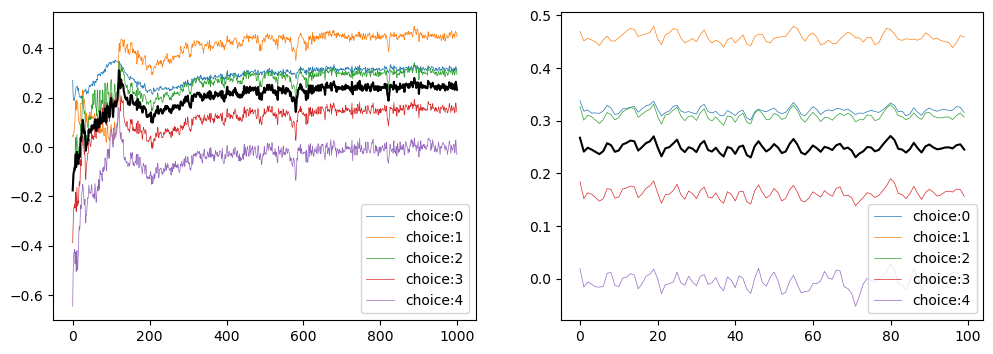

In [451]:
from scipy.signal import savgol_filter
filter = lambda x : savgol_filter(x, 2, 1)

plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(12,4))
for output in range(max_output):
    ax[0].plot(range(trainEpochs), filter(train_reward[:,output]), lw=0.5, label=f"choice:{output}")
    ax[1].plot(range(testEpochs), filter(test_reward[:,output]), lw=0.5, label=f"choice:{output}")

ax[0].plot(range(trainEpochs), filter(torch.mean(train_reward, dim=1)), c='k', lw=1.5)
ax[1].plot(range(testEpochs), filter(torch.mean(test_reward, dim=1)), c='k', lw=1.5)
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')

plt.show()

## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [217]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, da.dominoeAgent, da.bestLineAgent))
game.playGame()
game.printResults()

[[ 5  0 13  7]
 [ 5 11  0  6]
 [ 6  0 49 18]
 [ 7 39 29  0]
 [11 33 20  0]
 [ 6  2 26  0]
 [19 23 17  0]
 [ 0  3 24  7]
 [23 19  0  6]
 [ 7 24 40  0]]
[ 89 154 218  44]
The current winner is agent: 3 with a score of 44!


In [213]:
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)

player 0:  [' 0|8 ', ' 8|4 ', ' 4|5 ', ' 5|9 ', ' 9|9 ', ' 9|4 ', ' 4|6 ', ' 6|5 ', ' 5|3 ', ' 3|4 ', ' 4|2 ']
player 1:  [' 0|5 ', ' 5|7 ', ' 7|3 ', ' 3|3 ', ' 3|6 ', ' 6|0 ', ' 0|3 ', ' 3|2 ']
player 2:  [' 0|9 ', ' 9|8 ', ' 8|3 ', ' 3|9 ', ' 9|7 ', ' 7|2 ', ' 2|5 ', ' 5|1 ', ' 1|0 ', ' 0|2 ', ' 2|8 ']
player 3:  [' 0|7 ', ' 7|7 ', ' 7|8 ', ' 8|8 ', ' 8|5 ', ' 5|5 ']
dummy:  [' 0|4 ', ' 4|4 ', ' 4|7 ', ' 7|6 ', ' 6|9 ', ' 9|2 ', ' 2|1 ', ' 1|1 ', ' 1|8 ', ' 8|6 ', ' 6|1 ', ' 1|9 ']


In [195]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|8 ', ' 8|5 ', ' 5|5 ']
[' 9|3 ', ' 3|3 ', ' 3|5 ', ' 5|7 ']
[' 9|8 ', ' 8|0 ', ' 0|1 ', ' 1|7 ', ' 7|4 ', ' 4|6 ', ' 6|9 ', ' 9|1 ', ' 1|5 ', ' 5|4 ', ' 4|2 ', ' 2|7 ', ' 7|6 ', ' 6|8 ']
[' 9|5 ', ' 5|6 ', ' 6|6 ', ' 6|0 ', ' 0|0 ', ' 0|9 ', ' 9|4 ', ' 4|8 ', ' 8|1 ']
[' 9|2 ', ' 2|2 ', ' 2|0 ', ' 0|5 ', ' 5|2 ', ' 2|3 ', ' 3|8 ', ' 8|2 ', ' 2|6 ', ' 6|3 ', ' 3|4 ', ' 4|0 ', ' 0|3 ', ' 3|7 ', ' 7|7 ', ' 7|0 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


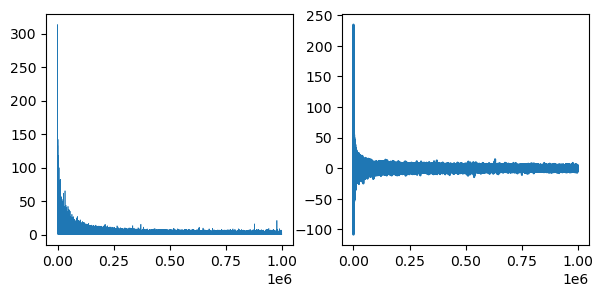

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()

In [206]:
print("hello")

hello
